In [3]:
import pandas as pd
import numpy as np
import plotnine as p9
import re
data = pd.read_csv('techscene.csv')

# Data cleaning

## Normalizing job titles

In order to make cleaning and analysis easier, we replace all uppercase letters in the data with lowercase. We also remove some instances of superfluous information from job titles, such as strings like "(m/f/d)" or "SEB | Tallinn".

In [2]:
for column in data.columns:#teeme kõik väiketähtedeks
  data[column]=data[column].str.lower()
#job_name
#remove (m/f/d),(m/f/x),| SEB, Tallinn,
data['job_name']=data['job_name'].str.replace('(m/f/d)', '').replace('(m/f/x)','').replace('| SEB, Tallinn','').replace('\"','')

Some of the data from the beginning of the scraping period doesn't include the field `domain`; the value of this field for these listings is `nan`. We can retroactively add these based on the title of the listing.

In [ ]:
data[data['domain'].isnan()].shape

In [115]:
data['domain'].unique()

array(['software-development', nan, 'front-end', 'back-end', 'mobile',
       'analytics', 'full-stack', 'other', 'devops-sre', 'data-science',
       'cyber-security', 'ai-ml', 'qa', 'sales', 'finance', 'marketing',
       'design', 'hr', 'customer-support', 'management'], dtype=object)

In [118]:
replacement_dict={#regex: domain,
  'software engineer|tarkvaraarendaja': 'software-development',
  'front-end|frontend|react': 'front-end',
  'back-end|backend': 'back-end',
  'android|ios': 'mobile',
  'devops': 'devops-sre',
  'data scientist': 'data-science'
  }
for index, row in data[data['domain'].isna()].iterrows():#iterate through all listings that have the 'domain' column as 'nan'
  matched=False
  for regex in replacement_dict.keys():
    if not matched and re.search(regex,row['job_name']):#check if any of the regexes in the dictionary match the name of the listing, if they do, add a domain from replacement_dict
      matched=True
      data.loc[index,'domain']=replacement_dict[regex]
      print(row['job_name']+': changed domain to '+replacement_dict[regex])#debugging
  if not matched:#debugging
    print(row['job_name']+' not matched')

## Compressing consecutive listings

Currently, our data contains every instance of a listing scraped in a day. For purposes of analysis, it might be helpful to compress the data so that consecutive appearances of one listing get turned into one single entry, with new fields `first_appeared` and `last_appeared`.

In [ ]:
"""
Groups data by company name, job name, and job link. 
Sorts the data by date added and creates blocks of consecutive job postings.
"""
def process_job_data(data):

    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Normalize text for comparison
    data['job_name'] = data['job_name'].str.lower()
    data['company_name'] = data['company_name'].str.lower()

    # Remove exact duplicates
    data = data.drop_duplicates()

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])

    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    for (company_name, job_name, job_link), group in grouped:
        group = group.sort_values('date_added')

        start_date = None
        prev_date = None

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        for current_date in group['date_added']:
            if start_date is None:
                start_date = current_date
                prev_date = current_date
            elif (current_date - prev_date).days > 1:
                # Special case: check only for 2024-09-06
                if (prev_date == pd.to_datetime('2024-09-05').date() and 
                    current_date == pd.to_datetime('2024-09-07').date()):
                    prev_date = current_date  # Assume continuity
                else:
                    # Save current block if gap is not special case
                    new_data = pd.concat([new_data, pd.DataFrame({
                        "company_name": [company_name],
                        "job_name": [job_name],
                        "domain": [domain],
                        "first_appeared": [start_date],
                        "last_appeared": [prev_date],
                        "job_link": [job_link]
                    })], ignore_index=True)
                    start_date = current_date

                start_date = current_date  # Start a new block

            prev_date = current_date

        # Save the last block
        new_data = pd.concat([new_data, pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [start_date],
            "last_appeared": [prev_date],
            "job_link": [job_link]
        })], ignore_index=True)

    return new_data

# Example usage:
# data = pd.read_csv('input.csv')
nd = data.copy()
processed_data = process_job_data(data)
#processed_data.to_csv('new_data!!!.csv', index=False)


In [119]:
data[data['domain'].isnan()].shape

,company_name,job_name,job_link,date_added,domain
6,nexd,"full-stack developer (php, vue.js)",https://www.nexd.com/career/full-stack-developer/,2024-03-26 00:00:00,NaN
27,nexd,"full-stack developer (php, vue.js)",https://www.nexd.com/career/full-stack-developer/,2024-03-26 00:00:00,NaN
29,novater solutions,full-stack developer,https://novater.com/careers/full-stack-developer/,2024-03-26 00:00:00,NaN
30,seb,full-stack software developer for baltic inter...,https://jobs.eu.lever.co/seb/2b1135be-e2e0-4f7...,2024-03-26 00:00:00,NaN
31,creditstar,full stack developer,https://apply.workable.com/j/9c81ddebd2,2024-03-26 00:00:00,NaN
...,...,...,...,...,...
737,luminor,senior compliance officer (assurance unit),https://luminorbank.teamtailor.com/jobs/354120...,2024-04-02 00:00:00,NaN
738,cybernetica,post-quantum cryptography engineer,https://cyber.teamdash.com/p/job/iqn79wzx/post...,2024-04-02 00:00:00,NaN
739,cybernetica,researcher,https://cyber.teamdash.com/p/job/pagseczx/rese...,2024-04-02 00:00:00,NaN
740,cybernetica,data architect,https://cyber.teamdash.com/p/job/knvredgr/data...,2024-04-02 00:00:00,NaN


In [22]:
"""
Groups data by company name, job name, and job link.
Finds the first appearance and last appearance dates.
"""

def process_job_data(data):
    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])
    
    # Group by unique identifying columns
    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    # Iterate through each unique group
    for (company_name, job_name, job_link), group in grouped:
        # Find the first and last appearance dates
        first_appeared = group['date_added'].min()
        last_appeared = group['date_added'].max()
        

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        # Create a new row for this unique entry
        new_row = pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [first_appeared],
            "last_appeared": [last_appeared],
            "job_link": [job_link]
        })
        
        # Append to new_data
        new_data = pd.concat([new_data, new_row], ignore_index=True)
    
    return new_data

# Example usage
# data = pd.read_csv('your_input_file.csv')  # Load your input data
nd = data.copy()
new_data = process_job_data(data)
#new_data.to_csv('new_data!!!!!!!.csv', index=False)  # Save processed data

In [ ]:
"""
Checks if first data has the same links as second data.
"""
def check_links(data, data2):

    links1 = data["job_link"].unique()
    links2 = data2["job_link"].unique()
    for link in links1:
        if link not in links2:
            print(link)

# Analyzing listings by time

## Patterns of posting new listings


## Identify listings that have been up for a long time
Sort by length, report results, are there any other common traits between these listings?


### What is the most popular weekday for posting new listings?

In [53]:
weekdays_mod7=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
#for leap years, doomsday is on January 4th, February 29th etc.
doomsdays_bymonth=[4,29,14,4,9,6,11,8,5,10,7,12]
def determine_weekday(s):
  #use the Doomsday algorithm for determining the day of the week based on date. see https://en.wikipedia.org/wiki/Doomsday_rule
  month=int(s[5:7])
  day=int(s[8:10])
  doomsday=doomsdays_bymonth[month-1]
  #anchor day for 2024 is Thursday, which corresponds to 4
  mod=(4 + (day - doomsday) + 35) % 7 
  return weekdays_mod7[mod]

#apply the function on every listing to get the weekday
data['weekday_added']=data['date_added'].apply(lambda x: determine_weekday(x))
  

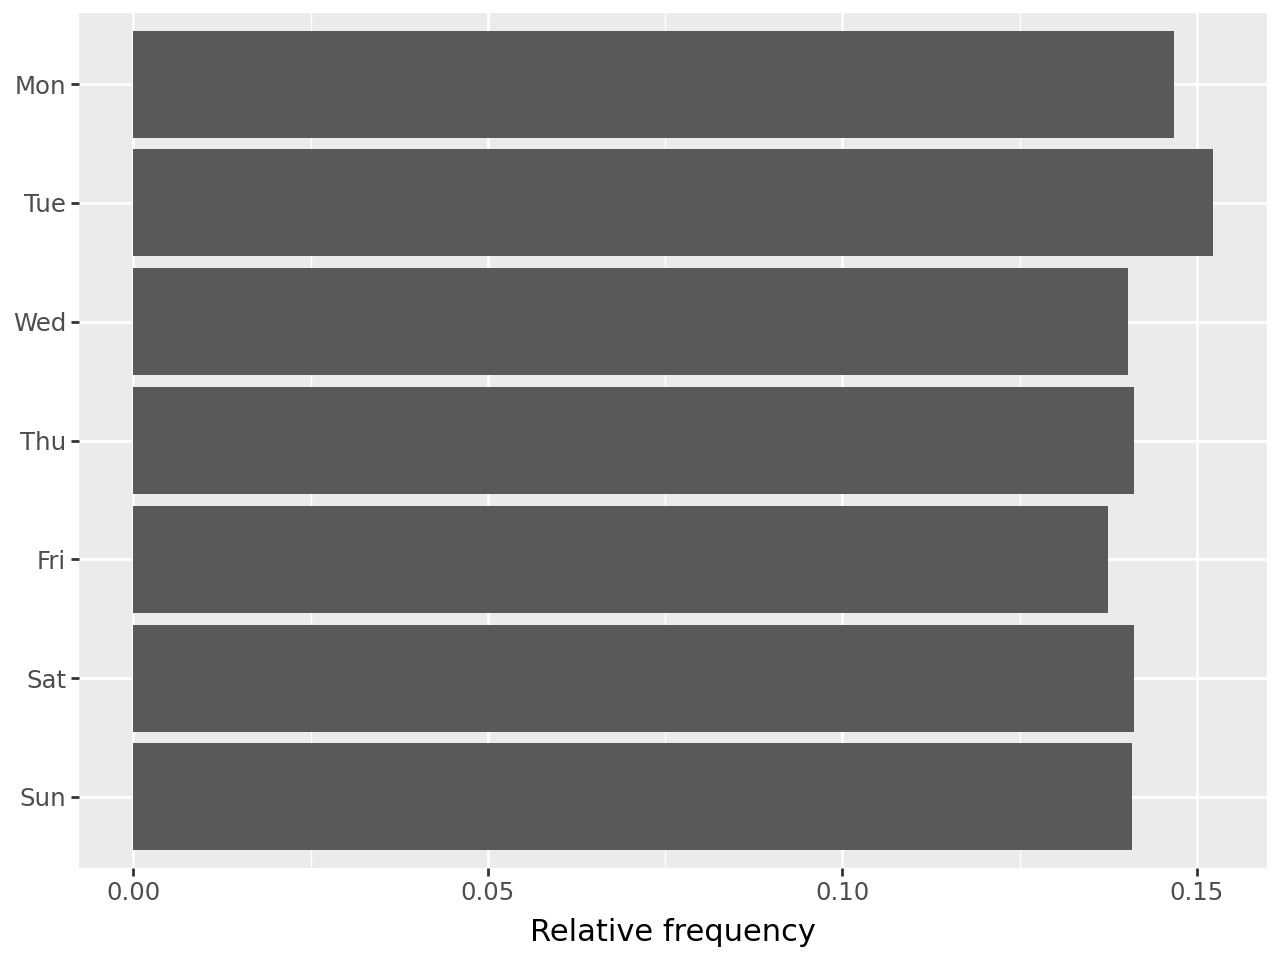

In [67]:
weekdays_sorted=['Sun','Sat','Fri','Thu','Wed','Tue','Mon']
weekday_cat=pd.Categorical(data['weekday_added'], categories=weekdays_sorted)

( p9.ggplot(
    data=data,
    mapping=p9.aes(x='weekday_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
)

## Identify listings that get posted repeatedly
Kasutame decision treed, et ennustada kuulutuse kordumist

# What domains are the most popular?

Sort by domain, report frequency

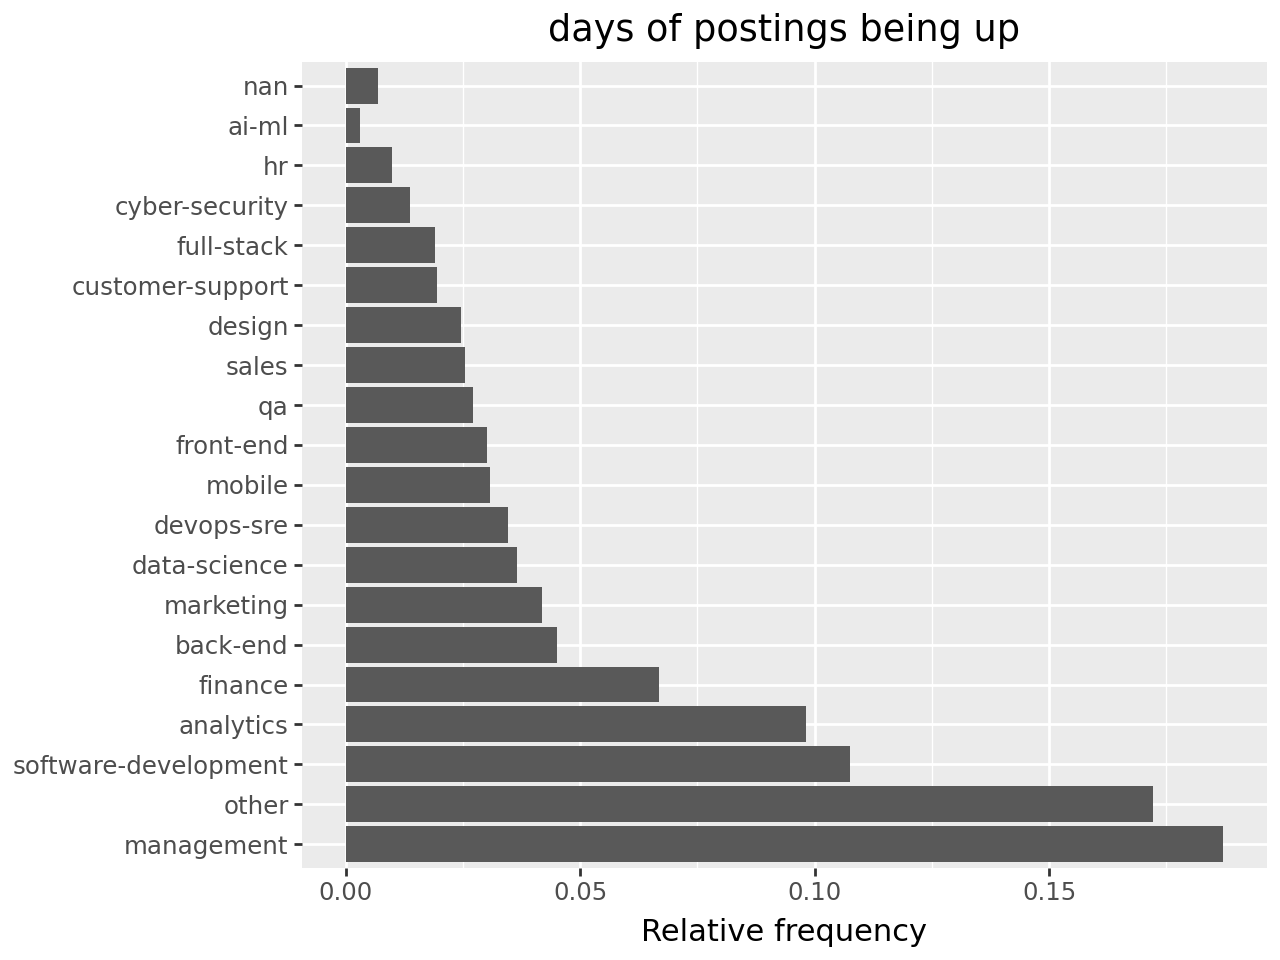

In [26]:
domains_sorted=data['domain'].value_counts().index.tolist()
domain_cat=pd.Categorical(data['domain'], categories=domains_sorted)

( p9.ggplot(
    data=data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("days of postings being up")
)

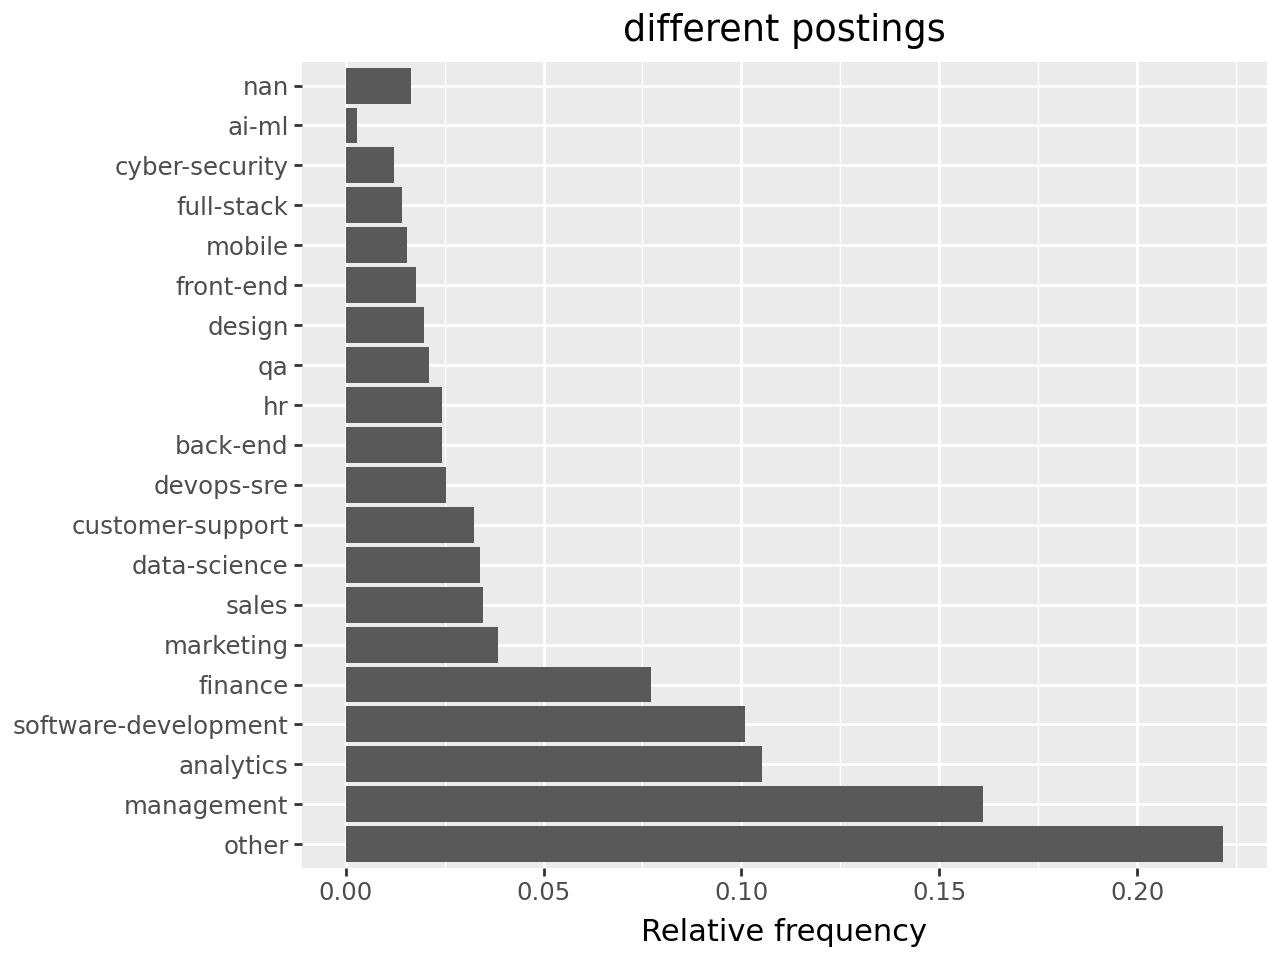

In [27]:
domains_sorted=new_data['domain'].value_counts().index.tolist()
domain_cat=pd.Categorical(new_data['domain'], categories=domains_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("different postings")
)

In [26]:
domain_counts_daily=data.groupby(['date_added','domain'])['domain'].count()
domain_counts_daily=domain_counts_daily.reset_index(name='counts')
domain_counts_daily


,date_added,domain,counts
0,2024-04-02 00:00:00,ai-ml,4
1,2024-04-02 00:00:00,analytics,72
2,2024-04-02 00:00:00,back-end,24
3,2024-04-02 00:00:00,customer-support,10
4,2024-04-02 00:00:00,cyber-security,4
...,...,...,...
4190,2024-11-10 00:00:00,mobile,11
4191,2024-11-10 00:00:00,other,53
4192,2024-11-10 00:00:00,qa,6
4193,2024-11-10 00:00:00,sales,3


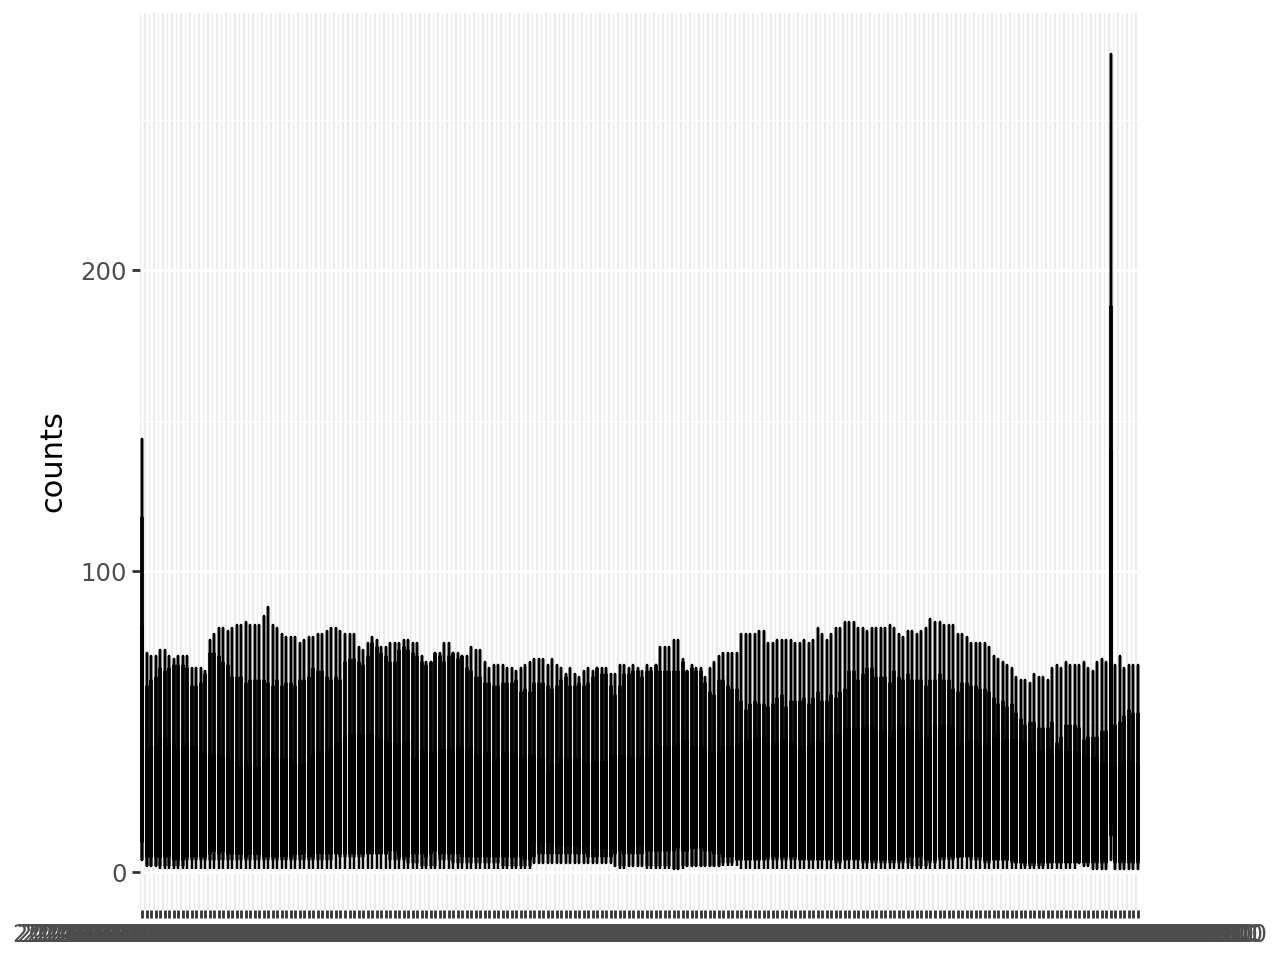

In [60]:
(p9.ggplot(
  data=domain_counts_daily,
  mapping=p9.aes(x='date_added',y='counts'))
+ p9.geom_line()
+ p9.labs(x='')#ticks by date
)

# What tech stacks are the most popular?
Sort by tech stack (if available), report frequency

# Who are the biggest hirerers?

In [73]:
new_data["company_name"].value_counts()

company_name
bolt          422
wise          304
luminor       153
seb           127
yolo group    117
             ... 
fortumo         2
rangeforce      2
nexd            2
textmagic       2
boku            1
Name: count, Length: 73, dtype: int64

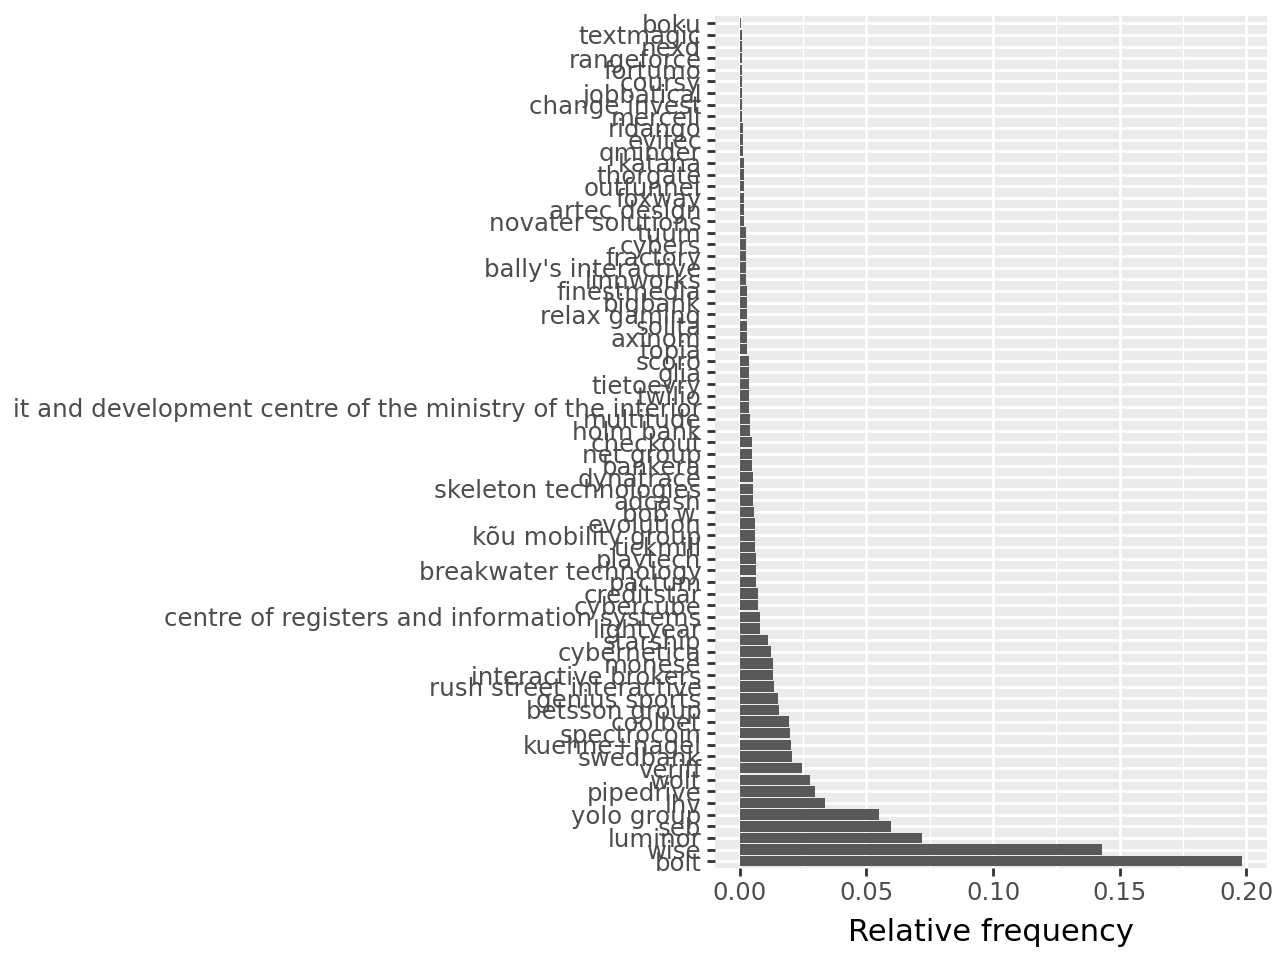

In [ ]:
company_name_sorted=new_data['company_name'].value_counts().index.tolist()
domain_cat=pd.Categorical(new_data['company_name'], categories=company_name_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("different postings")
)

